
# Solving Blackjack with Q-Learning and Monte Carlo Methods


In this notebook, I'll explore and solve the *BlackjackEnv* env considering the chips (1000 at beginning and then 10 round to play).

**Blackjack** is one of the most popular casino card games that is also
infamous for being beatable under certain conditions. This version of
the game uses an infinite deck (we draw the cards with replacement), so
counting cards won’t be a viable strategy in our simulated game.
Full documentation can be found at https://gymnasium.farama.org/environments/toy_text/blackjack

**Objective**: To win, your card sum should be greater than the
dealers without exceeding 21.

**Actions**: Agents can pick between two actions:
 - stand (0): the player takes no more cards
 - hit (1): the player will be given another card, however the player could get over 21 and bust

**Approach**: To solve this env by yourself, you can pick your
favorite discrete RL algorithm. The presented solution uses *Q-learning*
(a model-free RL algorithm).




## Imports and Environment Setup




In [29]:
# Author: Till Zemann
# License: MIT License
# Updated and modified by Michelle Peng

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

import math 
from mpl_toolkits.mplot3d import Axes3D
import copy
import pygame
from collections import defaultdict

env = gym.make("Blackjack-v1").unwrapped

In [30]:
# Print the env details
print(dir(env))  # Shows available attributes and methods
print(env.__dict__)  # Shows all instance variables

['__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_obs', '_np_random', '_np_random_seed', 'action_space', 'close', 'get_wrapper_attr', 'has_wrapper_attr', 'metadata', 'natural', 'np_random', 'np_random_seed', 'observation_space', 'render', 'render_mode', 'reset', 'sab', 'set_wrapper_attr', 'spec', 'step', 'unwrapped']
{'action_space': Discrete(2), 'observation_space': Tuple(Discrete(32), Discrete(11), Discrete(2)), 'natural': False, 'sab': True, 'render_mode': None, 'spec': EnvSpec(id='Blackjack-v1', entry_point='gymnasium.envs.toy_text.blackjack:BlackjackEnv', reward_threshol

In [31]:
help(env)

Help on BlackjackEnv in module gymnasium.envs.toy_text.blackjack object:

class BlackjackEnv(gymnasium.core.Env)
 |  BlackjackEnv(render_mode: Optional[str] = None, natural=False, sab=False)
 |
 |  Blackjack is a card game where the goal is to beat the dealer by obtaining cards
 |  that sum to closer to 21 (without going over 21) than the dealers cards.
 |
 |  ## Description
 |  The game starts with the dealer having one face up and one face down card,
 |  while the player has two face up cards. All cards are drawn from an infinite deck
 |  (i.e. with replacement).
 |
 |  The card values are:
 |  - Face cards (Jack, Queen, King) have a point value of 10.
 |  - Aces can either count as 11 (called a 'usable ace') or 1.
 |  - Numerical cards (2-9) have a value equal to their number.
 |
 |  The player has the sum of cards held. The player can request
 |  additional cards (hit) until they decide to stop (stick) or exceed 21 (bust,
 |  immediate loss).
 |
 |  After the player sticks, the dea

# helper functions

In [32]:
import numpy as np

def get_total(Input):
    """
    This function will calculate the maximum total of a hand in 21. 
    It will also take into consideration if the Deck has aces.  

    Returns: 
    Maxmum value of a deck of card 
    Args:
    Input:List of numbers representing  a hand 

    """
    Input=np.array(Input)
    #maximum player hand under or equal to 21 
    Max=0
    #check if the hand has an ace
    if 1 in set(Input):
        #put all aces in one array 
        aces=Input[Input==1]
        #all  other cards  in a second array 
        not_aces=Input[Input!=1]
        #try different posable combinations of aces as 1 or 11 
        for ace in range(len(aces)+1):
            #convert each  ace to an 11 
            aces[0:ace]=11
            #find the total of a particular combination 
            total=aces.sum()+not_aces.sum()
            # check if the total is 21 
            if total==21:
                Max=21
                break
            #check if the total is larger than Max value but less than 22 

            elif total>Max and total<22:
                #if so total is new max
                Max=total

    else:
        #determine  sum if no aces in the deck 
        Max=sum(Input)

    return Max  

def game_result (env,state,show=True):
    '''
    this function  will determine the results of  a game  of Black Jack after an episode only  tested for open AI  gym 
    Returns: 
    result:   used to debug result of a game like open AI  gym +1,drawing is 0, and losing is -1, None for error 
    Args:
    env: open ai gym black jack env
    state: state of open ai gym black jack env
    '''
    if show:
        print("state:",state)
        print("player has", env.player)
        print("the players current sum:{},dealer's one showing card:{}, usable ace:{}".format(state[0],state[1],state[2]))
    dealer_sum=get_total(env.dealer)
    result=None
    if show:
        print("dealer cards: {} and score: {} your score i: {} ".format(env.dealer,dealer_sum,state[0]))
    if state[0]>21:
        if show:
            print("Bust")
        result=-1
    elif dealer_sum>21:
        if show:
            print("agent wins")
        result=1  
        
    elif state[0]>dealer_sum and state[0]<22:
        if show:
            print("agent  wins")
        result=1
        
    elif  state[0]<dealer_sum and dealer_sum<22 : 
        if show:
            print("agent  loses")
        result=-1
    return result 

In [33]:
def plot_value_function(V):
    """
    plot the estimated value function for blackjack 
    Returns:  void plots value function 
    Args:
    V: a dictionary of estimated values for blackjack 
    """
    #range of player score  
    player=[state[0]  for state in  V.keys()]
    max_player=max(player)
    min_player=min(player)
    player_range=np.arange(min_player, 22, 1)
    #range of dealer score      
    dealer=[state[1]  for state in  V.keys()]
    max_dealer=max(dealer)
    min_dealer=min(dealer)
    dealer_range=np.arange(min_dealer, 11, 1)
    #empty array for the value function, first access in the players score second  is the dealer, third is if  there  is an ace    
    V_plot=np.zeros((21-min_player+1,max_dealer-min_dealer+1,2))
    #create a mesh grid for plotting 
    X,Y = np.meshgrid(dealer_range,player_range)

    #populate an array  of values for different  scores not including losing scores 
    for (player,dealer,ace),v in V.items():
        if player<=21 and dealer<=21:
            V_plot[player-min_player,dealer-min_dealer,(1*ace)]=V[(player,dealer,ace)]

    #plot surface        
    fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': '3d'})
    ax[0].plot_wireframe(X,Y, V_plot[:,:,0])
    ax[0].set_title('no ace')
    ax[0].set_xlabel('dealer')
    ax[0].set_ylabel('player ')
    ax[0].set_zlabel('value function')
    ax[1].plot_wireframe(X,Y, V_plot[:,:,1])
    ax[1].set_title('no ace')
    ax[1].set_xlabel('dealer')
    ax[1].set_ylabel('player ')
    ax[1].set_zlabel('value function')
    ax[1].set_title(' ace')
    fig.tight_layout()
    plt.show()

    #plot top view of the surface     
    fig, ax = plt.subplots(nrows=1, ncols=2)   
    ax[0].imshow((V_plot[:,:,0]),extent =[1,10,21,4])
    ax[0].set_title('no ace')
    ax[0].set_xlabel('dealer')
    ax[0].set_ylabel('player ')   
    im=ax[1].imshow(V_plot[:,:,1],extent =[1,10,21,4])
    ax[1].set_title('ace')
    ax[1].set_xlabel('dealer')
    fig.colorbar(im, ax=ax[1])

In [34]:
def plot_policy_blackjack(policy):
    """
    plot the policy for blackjack 
    Returns:  void plots policy function 
    Args:
    policy: a dictionary of estimated values for blackjack 
    """    
    #range of player score 
    player=[state[0]  for state in  policy.keys()]
    max_player=max(player)
    min_player=min(player)
    #this vale is use in RL book 
    #min_player=12
    player_range=np.arange(min_player, 22, 1)
    #range of dealer score      
    dealer=[state[1]  for state in policy.keys()]
    max_dealer=max(dealer)
    min_dealer=min(dealer)
    dealer_range=np.arange(min_dealer, 11, 1)
    #empty array for the value function, first access in the players score second  is the dealer, third is if  there  is an ace    
    policy_plot=np.zeros((21-min_player+1,max_dealer-min_dealer+1,2))
    #create a mesh grid for plotting 
    X,Y = np.meshgrid(dealer_range,player_range)
    
    
    #populate an array  of values for different  policy not including losing states above 21 
    for (player,dealer,ace),v in policy.items():
        if player<=21 and dealer<=10 and player>=min_player:
            policy_plot[player-min_player,dealer-min_dealer,(1*ace)]=policy[(player,dealer,ace)]

    
    fig, ax = plt.subplots(nrows=1, ncols=2)   
    ax[0].imshow((policy_plot[:,:,0]),cmap=plt.get_cmap('GnBu', 2),extent =[1,10,21,4])
    ax[0].set_title('no ace')
    ax[0].set_xlabel('dealer')
    ax[0].set_ylabel('player ') 
    

    ax[1].set_title('ace')
    ax[1].set_xlabel('dealer')
    im=ax[1].imshow(policy_plot[:,:,1],extent =[1,10,21,4],cmap=plt.get_cmap('GnBu', 2))
    fig.colorbar(im, ax=ax[1],ticks=[0 , 1])

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_blackjack_value_function(V, title="Estimated Value Function"):
    """
    Plots the estimated value function for Blackjack in a 3D surface plot and heatmap.
    
    Args:
        V (dict): A dictionary mapping (player_sum, dealer_card, usable_ace) to estimated values.
        title (str): Title of the plot.
    """
    # Define ranges
    player_range = np.arange(12, 22)  # X-axis: Player sum from 12 to 21
    dealer_range = np.arange(1, 11)   # Y-axis: Dealer card from 1 (Ace) to 10

    # Initialize value grids (now transposed)
    value_grid_no_ace = np.zeros((len(dealer_range), len(player_range)))  # Shape: (dealer, player)
    value_grid_ace = np.zeros((len(dealer_range), len(player_range)))

    # Populate value grids (swapping axes)
    for (player_sum, dealer_card, usable_ace), value in V.items():
        if 12 <= player_sum <= 21 and 1 <= dealer_card <= 10:
            row = dealer_card - 1  # Now dealer is the row (Y-axis)
            col = player_sum - 12  # Now player is the column (X-axis)
            if usable_ace:
                value_grid_ace[row, col] = value
            else:
                value_grid_no_ace[row, col] = value

    # Create figure with 3D surface plots
    fig = plt.figure(figsize=(12, 5))
    fig.suptitle(title, fontsize=16)

    # Create mesh grid for 3D plot
    X, Y = np.meshgrid(player_range, dealer_range)

    # 3D Plot (No Usable Ace)
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(X, Y, value_grid_no_ace, cmap="viridis", edgecolor="none")
    ax1.set_title("Value Function: No Usable Ace")
    ax1.set_xlabel("Player Sum")
    ax1.set_ylabel("Dealer Showing")
    ax1.set_zlabel("Value")
    ax1.view_init(20, 220)  # Set 3D view angle

    # 3D Plot (With Usable Ace)
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    ax2.plot_surface(X, Y, value_grid_ace, cmap="viridis", edgecolor="none")
    ax2.set_title("Value Function: With Usable Ace")
    ax2.set_xlabel("Player Sum")
    ax2.set_ylabel("Dealer Showing")
    ax2.set_zlabel("Value")
    ax2.view_init(20, 220)  # Set 3D view angle

    plt.tight_layout()
    plt.show()

    # Create figure with 2D heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title, fontsize=16)

    # Heatmap settings
    heatmap_kwargs = {"linewidth": 0, "annot": False, "cmap": "viridis", "cbar": True}

    # Value heatmap (No Usable Ace)
    ax1 = sns.heatmap(value_grid_no_ace, ax=axes[0], **heatmap_kwargs)
    ax1.set_title("Value Function: No Usable Ace")
    ax1.set_xlabel("Player Sum")
    ax1.set_ylabel("Dealer Showing")
    ax1.set_xticklabels(range(12, 22))
    ax1.set_yticklabels(["A"] + list(range(2, 11)), rotation=0)

    # Value heatmap (With Usable Ace)
    ax2 = sns.heatmap(value_grid_ace, ax=axes[1], **heatmap_kwargs)
    ax2.set_title("Value Function: With Usable Ace")
    ax2.set_xlabel("Player Sum")
    ax2.set_ylabel("Dealer Showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), rotation=0)

    plt.tight_layout()
    plt.show()

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

def plot_blackjack_policy(policy, title="Optimal Blackjack Policy"):
    """
    Plots a Blackjack policy as a heatmap with dealer on Y-axis and player on X-axis.
    
    Args:
        policy (dict): A dictionary mapping (player_sum, dealer_card, usable_ace) to actions (0=stick, 1=hit).
        title (str): Title of the plot.
    """
    # Define ranges
    player_range = np.arange(12, 22)  # X-axis: Player sum from 12 to 21
    dealer_range = np.arange(1, 11)   # Y-axis: Dealer card from 1 (Ace) to 10

    # Initialize policy grids (now transposed)
    policy_grid_no_ace = np.zeros((len(dealer_range), len(player_range)))  # Shape: (dealer, player)
    policy_grid_ace = np.zeros((len(dealer_range), len(player_range)))

    # Populate policy grids (swapping axes)
    for (player_sum, dealer_card, usable_ace), action in policy.items():
        if 12 <= player_sum <= 21 and 1 <= dealer_card <= 10:
            row = dealer_card - 1  # Now dealer is the row (Y-axis)
            col = player_sum - 12  # Now player is the column (X-axis)
            if usable_ace:
                policy_grid_ace[row, col] = action
            else:
                policy_grid_no_ace[row, col] = action

    # Create figure with 2 subplots (usable ace & no usable ace)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title, fontsize=16)

    # Heatmap settings
    heatmap_kwargs = {"linewidth": 0, "annot": True, "cmap": "Accent_r", "cbar": False}

    # Policy heatmap (No Usable Ace)
    ax1 = sns.heatmap(policy_grid_no_ace, ax=axes[0], **heatmap_kwargs)
    ax1.set_title("Policy: No Usable Ace")
    ax1.set_xlabel("Player Sum")
    ax1.set_ylabel("Dealer Showing")
    ax1.set_xticklabels(range(12, 22))  # X-axis: Player sum (12-21)
    ax1.set_yticklabels(["A"] + list(range(2, 11)), rotation=0)  # Y-axis: Dealer (1=A, 2-10)

    # Policy heatmap (With Usable Ace)
    ax2 = sns.heatmap(policy_grid_ace, ax=axes[1], **heatmap_kwargs)
    ax2.set_title("Policy: With Usable Ace")
    ax2.set_xlabel("Player Sum")
    ax2.set_ylabel("Dealer Showing")
    ax2.set_xticklabels(range(12, 22))  # X-axis: Player sum (12-21)
    ax2.set_yticklabels(["A"] + list(range(2, 11)), rotation=0)  # Y-axis: Dealer (1=A, 2-10)

    # Add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))

    plt.tight_layout()
    plt.show()

In [37]:
def average_wins(env,policy=None,episodes=10):
    """
    This function calculates the average number of wins for a game of blackjack given a policy.
    If no policy is provided a random policy is selected.
    Returns: average_wins: the average number of wins 
    std_wins: the average number of wins 
    Args:
    env:AI gym balckjack envorment object 
    policy:policy for blackjack if none a random  action will be selected 
    episodes: number of episodes 
    """
    env = env.unwrapped
    win_loss=np.zeros(episodes)

    for episode in range(episodes):
        state, info=env.reset()
        done=False

        while (not(done)):
            if policy and isinstance(policy[state],np.int64):
                 
                action=policy[state]
                
            else:
                action=env.action_space.sample()

            state,reward,terminated,truncated,info=env.step(action)
            done = terminated or truncated
        result=game_result(env,state,show=False)
        if reward==1:
            win_loss[episode]=1
        else:
            win_loss[episode]=0  

        
    average_wins=win_loss.mean()
    std_win=win_loss.std()/np.sqrt(episodes)

    return average_wins ,std_win

## Observing the env

First of all, we call ``env.reset()`` to start an episode. This function
resets the env to a starting position and returns an initial
``observation``. We usually also set ``done = False``. This variable
will be useful later to check if a game is terminated (i.e., the player wins or loses).




In [38]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

The observation of is a 3-tuple of: the player's (you) current sum, the dealer's one showing card (1-10 where 1 is ace), and whether or not the player holds a usable ace (0 or 1) or (`True` or `False`).

    Tuple(the players current sum, dealer's one showing card player holds, usable ace (0 or 1) )
Then we can explain `Tuple(Discrete(32), Discrete(11), Discrete(2))` as
* The highest score you can achieve is (11,10,11), and the lowest is (1), so there are 32 states for the player's score.
* The dealer only shows one card, which can be anything from 1 to 11
* The 'usable ace' space is True/False, so the size of the space is 2.

So there are $32 \times 11 \times 2 = 704$ possible states. Note that we have to reset the env to start working with it. This function resets the game env to what it was when you started the game. It will return the initial state $S_0$:

In [39]:
observation, info=env.reset()
for i in range(15):
    print("s_{}={}".format(i, env.observation_space.sample())) 

s_0=(9, 9, 0)
s_1=(5, 0, 1)
s_2=(14, 1, 0)
s_3=(14, 4, 0)
s_4=(1, 8, 1)
s_5=(29, 9, 0)
s_6=(22, 9, 1)
s_7=(18, 4, 0)
s_8=(3, 1, 0)
s_9=(0, 5, 0)
s_10=(2, 0, 1)
s_11=(17, 6, 0)
s_12=(22, 9, 1)
s_13=(5, 4, 1)
s_14=(9, 3, 1)


In [40]:
observation

(14, 10, 0)

## Executing an action

After receiving our first observation, we are only going to use the
``env.step(action)`` function to interact with the env. This
function takes an action as input and executes it in the env.
Because that action changes the state of the env, it returns
four useful variables to us. These are:

-  ``next_state``: This is the observation that the agent will receive
   after taking the action.
-  ``reward``: This is the reward that the agent will receive after
   taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or
   not the env has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether
   the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional
   information about the env.

The ``next_state``, ``reward``,  ``terminated`` and ``truncated`` variables are
self-explanatory, but the ``info`` variable requires some additional
explanation. This variable contains a dictionary that might have some
extra information about the env, but in the Blackjack-v1
env you can ignore it. For example in Atari environments the
info dictionary has a ``ale.lives`` key that tells us how many lives the
agent has left. If the agent has 0 lives, then the episode is over.

Note that it is not a good idea to call ``env.render()`` in your training
loop because rendering slows down training by a lot. Rather try to build
an extra loop to evaluate and showcase the agent after training.




We can either $hit$ or $stay$: $$ A_t =0   (\textit{stay})\quad A_2 =1   \textit{(hit)}$$

In [41]:
env.action_space.n

2

In [42]:
episodes=2
sum_=0
result=0
error=0

#setting the seed for reproduceability

for episode in range(episodes):
    state, info=env.reset()
    done=False
    print("_________________________________________")
    print("episode {}".format(episode))
   

    print("state:",state)
    print("player has", env.player)
    print("the players current sum: {},\n  dealer's one showing card: {}, usable ace: {}".format(state[0],state[1],state[2]))
    print('dealer', env.dealer)
    while (not(done)):
    
        action = env.action_space.sample()
       
        if action:
            print("hit")
        else:
            print("stay")
        
        print("action:",action)

        state,reward,done,truncated,info = env.step(action)
        
    print("Done :", done)
    result=game_result(env,state)
    sum_+=reward
sum_

_________________________________________
episode 0
state: (5, 5, 0)
player has [3, 2]
the players current sum: 5,
  dealer's one showing card: 5, usable ace: 0
dealer [5, 6]
stay
action: 0
Done : True
state: (5, 5, 0)
player has [3, 2]
the players current sum:5,dealer's one showing card:5, usable ace:0
dealer cards: [5, 6, 1, 1, 9] and score: 0 your score i: 5 
agent  wins
_________________________________________
episode 1
state: (13, 10, 0)
player has [9, 4]
the players current sum: 13,
  dealer's one showing card: 10, usable ace: 0
dealer [10, 8]
hit
action: 1
hit
action: 1
stay
action: 0
Done : True
state: (18, 10, 0)
player has [9, 4, 1, 4]
the players current sum:18,dealer's one showing card:10, usable ace:0
dealer cards: [10, 8] and score: 18 your score i: 18 


1.0

Once ``terminated = True`` or ``truncated=True``, we should stop the
current episode and begin a new one with ``env.reset()``. If you
continue executing actions without resetting the env, it still
responds but the output won’t be useful for training (it might even be
harmful if the agent learns on invalid data).




## Q-learning

Let’s build a ``Q-learning agent`` to solve *Blackjack-v1*! We’ll need
some functions for picking an action and updating the agents action
values. To ensure that the agents explores the env, one possible
solution is the ``epsilon-greedy`` strategy, where we pick a random
action with the percentage ``epsilon`` and the greedy action (currently
valued as the best) ``1 - epsilon``.




In [43]:
class BlackjackAgent:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, env, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the env
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

To train the agent, we will let the agent play one episode (one complete
game is called an episode) at a time and then update it’s Q-values after
each step (one single action in a game is called a step).

The agent will have to experience a lot of episodes to explore the
env sufficiently.

Now we should be ready to build the training loop.




In [44]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

Great, let’s train!

Info: The current hyperparameters are set to quickly train a decent agent.
If you want to converge to the optimal policy, try increasing
the n_episodes by 10x and lower the learning_rate (e.g. to 0.001).




In [45]:
env= gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(env, obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the env is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:16<00:00, 6156.82it/s]


## Visualizing the training




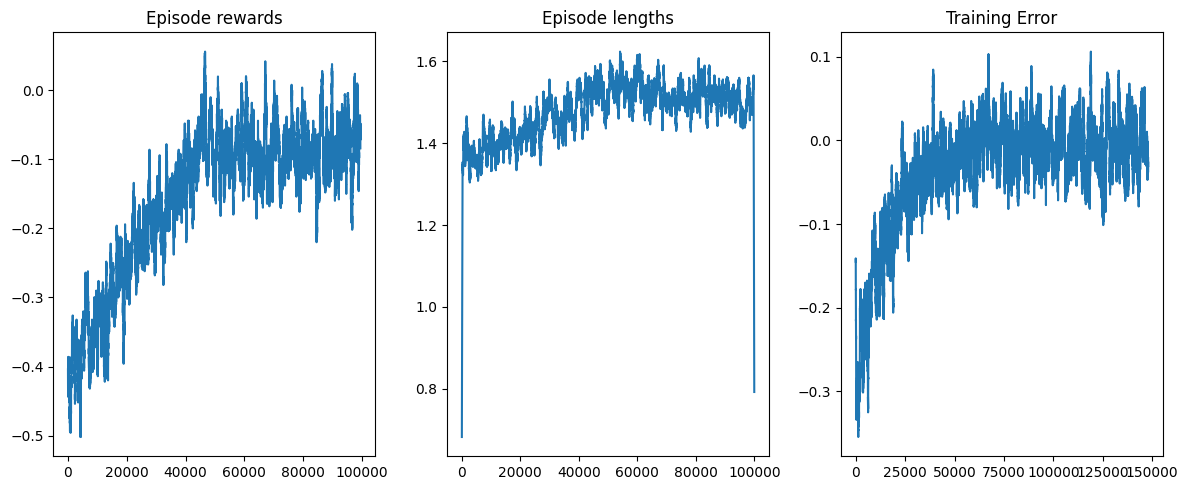

In [46]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

## Visualising the policy



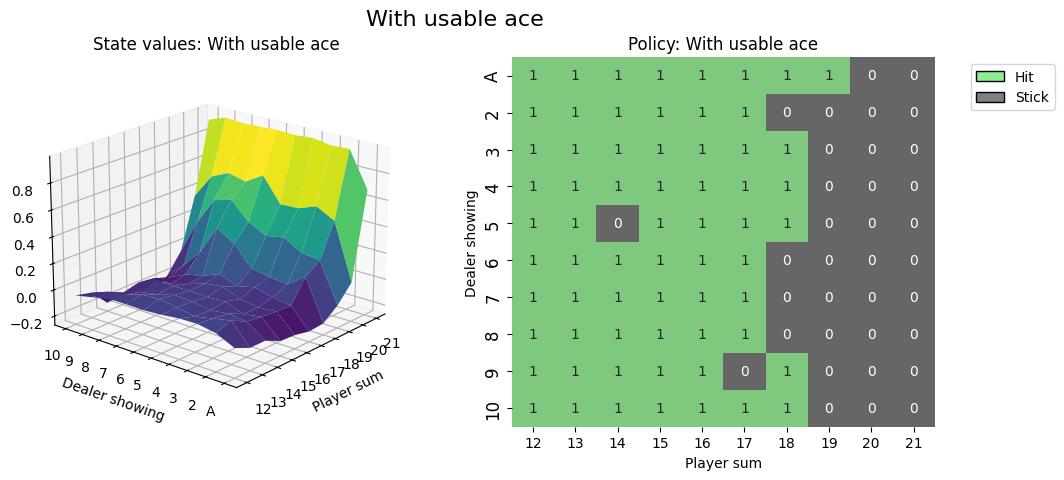

In [47]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

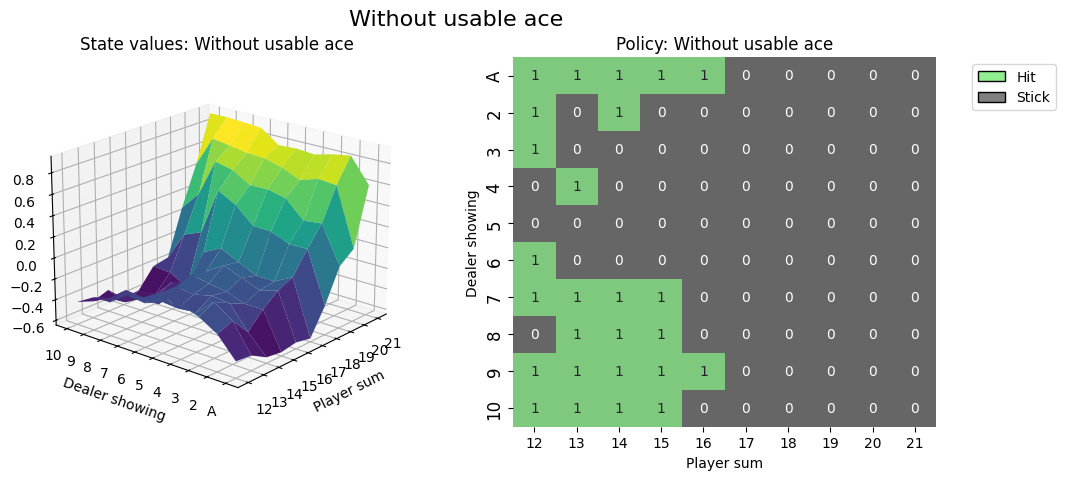

In [48]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

It's good practice to call env.close() at the end of your script,
so that any used resources by the env will be closed.




## Monte Carlo Method 
#### Let's talk about the heart of our algorithm, the Value function that we will be using and how it estimates the reward for each action given the state. 

Monte Carlo Method was invented by invented by Stanislaw Ulman in the 1940s, when trying to calculate the probability of a successful Canfield solitaire (He was sick and had nothing better to do). Ulman randomly lay the cards out and simply calculated the number of successful plays. We will apply the same approach to create our value function. The basic principle of Monte Carlo method can be summarized in 4 steps: 

1. Define the Domain of Possible inputs 
2. Generate inputs randomly from a probability distribution over the domain
3. Perform a deterministic computation on the inputs
4. Average the results

Before we can see it in action let's define a few things. Review that **Episode** is an agent-environment interactions from initial to final states which constists of steps in a in a discrete-time game. 

Monte Carlo reinforcement learning learns from **episodes of experience**, it functions by setting the value function equal to the empirical mean return.
Let's assume that we have some initialized policy $\pi$ that our agent follows. Then let's play a game once and gain the following episode: 

$$(S_1, A_1, R_1)\rightarrow(S_2, A_2, R_2)\rightarrow  (S_3, A_3, R_3)\rightarrow ...\rightarrow  (S_n) \sim \pi$$

Now let's look at an total expected reward of taking an Action $A_t$ in the state $S_t$, where t is some **time step**. 

* At **time step** $t=0$ (the first time step), the environment (including the agent) is in some state $S_t = S_0$ (the initial state), takes an action $A_t = A_0$ (the first action in the game) and receives a reward $R_t = R_0$ and the environment (including the agent) moves to a next state $S_{0+1} = S_{1}$

Let's define a function $G$, which will just give us the expected total discounted reward at each time step: 
$$G(t) = R_t +\gamma R_{t+1}+\gamma^2 R_{t+2} + ...+ \gamma^{k}R_{t+k}$$

Discount factor $\gamma \in \left[0,1\right]$ is an important constant. We add the initial return $R_1$ as it is, without modifying the value, then to get the total reward we are adding $R_{t+1}$ but note that the value is multiplied by $0\leq \gamma \leq 1$, so $R_{t+1}$ is only partially added to $R_1$, $R_{t+2}$ is multiplied by $\gamma^2$, $R_{t+3}$ is multiplied by $\gamma^3$ and so on. Gamma determines how much the reinforcement learning agents cares about rewards in the distant future relative to those in the immediate future. Note that if $\gamma=0$ then total expected return will be defined just by initial reward, so agent will only learn and care about actions that produce an immediate reward. 

Now we can define our action-value function $Q_{\pi}(S, A)$ for some sate $S$ and action $A$ as: 
$$Q_{\pi}(S, A) = E_{\pi}\left[G(t)|S_t = S, A_t = A \right ]$$

So value function returns the expected value of a total discounted reward $G(t)$ for the time step $t$ at which $S_t = S$ and $A_t = A$. So, as an example, our state-value for the start state $S = 0$ should look something like:


Now, after completing a series of episodes in the game, how can we adjust the expected values, or a bigger question is how's the learning process happening in Monte Carlo Method. For it we will use the concept of **Incremental means**. 

**Incremental means**, is just an average of values that's computed incrementally. Let $x_1, x_2,..., x_n$ be the set of values, Let $\mu_1, \mu_2, ... , \mu_{n-1}$ be an sequence of means, where $\mu_1 = x_1$, $\mu_2 = \dfrac{x_1+x_2}{2}$ and $\mu_3 = \dfrac{x_1+x_2+x_3}{3}$ and so on. Let's see how the mean is defined incrementally:

\begin{align*} 
\mu_n &= \frac{1}{n}\sum_{i = 1}^{n}x_i\\\\\\  
&= \frac{1}{n} (x_n +  \sum_{i = 1}^{n-1}x_i)\\\\
&= \frac{1}{n}(x_n +  (n-1)\mu_{n-1})\\\\
&= \mu_{n-1} + \frac{1}{n}(x_n - \mu_{n-1})
\end{align*}


Now we can put everything together to describe the Monte Calro Method Learning Process. Let's have an episode: 
$$(S_1, A_1, R_1)\rightarrow(S_2, A_2, R_2)\rightarrow  (S_3, A_3, R_3)\rightarrow ...\rightarrow  (S_n) \sim \pi$$

For each (state, action) pair we will keep track of the number of times this (state, action) was visited, let's define function $N(s_t,a_t)$, then every time we visit (state, action) we will update the visits counter and then adjust the running mean:
\begin{align*}
N(S_t, A_t)&+=1\\\\\\
Q(S_t, A_t)&+= \frac{1}{N(S_t, A_t)}(G(t) - Q(S_t, A_t))
\end{align*}

Let's look for at an example episode where we update our Q function:

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0EP1EN/Screenshot%202022-11-23%20at%2011.58.48%20AM.png" width="50%" alt="iris image">

Now we can see how in this episode, before the game begins the number of visits of this state with this action is 0, then the game starts and the number of visits functions is updated. Return is $0$ in the beginning. The action  is made, by using the predefined policy, we are changing the state and the reward is received since we have more than a dealer. The total reward is updated and the Q function is updated by calculating the average reward of making action $0$ in this state. Since it was the first time this state action pair was visited, we are just performing $1/1$ so we get $1$.

So now we know how to update the action-value function and how to use it in combination with our policy to maximize the rewards, it can be summarized as: 
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0O9IEN/Screenshot%202022-11-08%20at%201.27.51%20PM.png" width="50%" alt="iris image">

Monte Carlo algorithm/method is a type of **model-free** reinforcement learning, since the agent does not use predictions of the environment response, so it's not trying to create a statistical **model** of the environment.

Before implementing it, we will add a few more tricks and parameters to make this  method more efficient.


## Improving Monte Carlo with First Starts:
This concept is an important strategic decision that you have to make every time you build an episode based learning algorithm. Note that every episode, we update our Q function, based on states and actions that were visited, some state-action pairs can be visited more than one per episode. **Every-Visit MC** is Monte Carlo algorithm that averages returns for every time state-action pair is visited in an episode, where **First-visit MC** averages returns only for first time state-action pair is visited in an episode. 

Let's check its implementation in the **First-visit MC** pseudo-code: 

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0EP1EN/Screenshot%202022-11-23%20at%2012.33.51%20PM.png" width="50%" alt="iris image">

Where $T$ is the last step in the episode, $T-1$ is the second last one and so on.

Since, it's impossible to have the same state appearing more than once in Blackjack episode, we will only use the First-visit implementation. 


## Improving Monte Carlo with Exploring-Starts:
Note that in big and complicated environments not every (state,action) pair may be visited during the learning process. One possible solution to this problem may be adding **exploring-starts** method. In the beginning of each episode we are always starting in the initial state $S$, but with exploring-starts we will choose our starting state randomly. **Exploring-starts** is specifying that episodes start in a state–action pair, and that every pair has a nonzero probability of being selected as the start.

Let's check some pseudo code, to see how exploring-starts can be implemented in to our Monte Carlo algorithm. 

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX06PMEN/Screenshot%202022-11-09%20at%2012.24.33%20AM.png" width="50%" alt="iris image">

As you can see the main part, the only thing that changes in the code itself, is that the initial state of each episode is chosen randomly, the rest of Monte Carlo Algorithm remains unchanged.

Note that **Exploring-starts** is partially implemented in Black Jack environment by default, since player gets a random card combination in the beginning of each game, so what's left for us is to choose a random action, to generate a random initial state-action pair. 

<p style='color: blue'>Now let's implement it in our new code:</p>

In [49]:
import numpy as np
import gymnasium as gym
from collections import defaultdict

def monte_carlo_ES(env, N_episodes=100000, discount_factor=0.95, first_visit=True, epsilon=0.1, theta=0.0001):
    """
    Monte Carlo Exploring Starts for Blackjack.
    
    Returns:
    - policy: A dictionary mapping states to the best action (0=stick, 1=hit)
    - V: Estimated state values
    - Q: Estimated action values
    - DELTA: List of max changes in value function per iteration
    
    Args:
    - env: Gymnasium Blackjack environment
    - N_episodes: Number of episodes to run
    - discount_factor: Discount factor (gamma)
    - first_visit: Use first-visit MC if True, otherwise every-visit MC
    - epsilon: Exploration rate
    - theta: Convergence threshold
    """
    # Value function and action-value function
    V = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Q[state] is an array of action values
    
    # Count visits
    NumberVisitsValue = defaultdict(float)  # State visit counts
    NumberVisits = defaultdict(float)  # State-action visit counts
    
    # Policy dictionary
    policy = defaultdict(int)  # Store best action for each state
    
    # Store max difference in value function for convergence check
    DELTA = []

    for i in range(N_episodes):
        delta = 0
        episode = []  # Stores {'state', 'action', 'reward'}
        
        # Reset environment
        state, _ = env.reset()
        done = False
        
        # Choose an initial action randomly
        action = np.random.randint(env.action_space.n)
        episode.append({'state': state, 'action': action, 'reward': 0.0})
        
        # Store state-action pairs for first-visit check
        state_action = [(state, action)]
        
        while not done:
            # Take action in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated  # Ensure game termination is handled

            # Select next action based on policy (ε-greedy)
            if state in policy:
                if np.random.rand() < epsilon:
                    action = np.random.randint(env.action_space.n)
                else:
                    action = policy[state]
            else:
                action = np.random.randint(env.action_space.n)
            
            # Append step to episode
            episode.append({'state': next_state, 'action': action, 'reward': reward})
            state_action.append((next_state, action))
            
            state = next_state  # Update state
        
        # Reverse the episode to calculate returns from last to first state
        episode.reverse()
        state_action.reverse()

        # Compute return G
        G = 0.0

        for t, step in enumerate(episode):
            G = discount_factor * G + step['reward']

            if first_visit:
                # Check if this is the first visit to (state, action)
                if (step['state'], step['action']) not in set(state_action[t+1:] if t+1 < len(state_action) else []):
                    NumberVisits[step['state'], step['action']] += 1
                    NumberVisitsValue[step['state']] += 1
                    
                    # Update Q using incremental mean
                    Q[step['state']][step['action']] += (1 / NumberVisits[step['state'], step['action']]) * (G - Q[step['state']][step['action']])
                    
                    # Update V
                    v_old = V[step['state']]
                    V[step['state']] += (1 / NumberVisitsValue[step['state']]) * (G - V[step['state']])

                    # Update policy (argmax over Q)
                    policy[step['state']] = np.random.choice(np.where(Q[step['state']] == np.max(Q[step['state']]))[0])
                    
                    # Track convergence
                    delta = max(delta, abs(v_old - V[step['state']]))

            else:
                # Every-visit version
                NumberVisits[step['state'], step['action']] += 1
                NumberVisitsValue[step['state']] += 1
                
                # Update Q using incremental mean
                Q[step['state']][step['action']] += (1 / NumberVisits[step['state'], step['action']]) * (G - Q[step['state']][step['action']])
                
                # Update V
                v_old = V[step['state']]
                V[step['state']] += (1 / NumberVisitsValue[step['state']]) * (G - V[step['state']])

                # Update policy
                policy[step['state']] = np.random.choice(np.where(Q[step['state']] == np.max(Q[step['state']]))[0])

                # Track convergence
                delta = max(delta, abs(v_old - V[step['state']]))

        DELTA.append(delta)
        if delta < theta:
            break  # Stop if changes in value function are small

    return policy, V, Q, DELTA

In [50]:
policy, V, Q, DELTA= monte_carlo_ES(env,N_episodes=100000, discount_factor=1,epsilon = 0.1,first_visit=True,theta=0)  

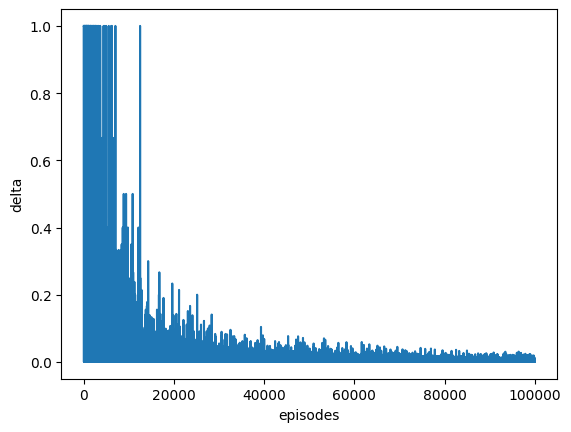

In [51]:
plt.plot(DELTA)
plt.xlabel("episodes")
plt.ylabel("delta")
plt.show()

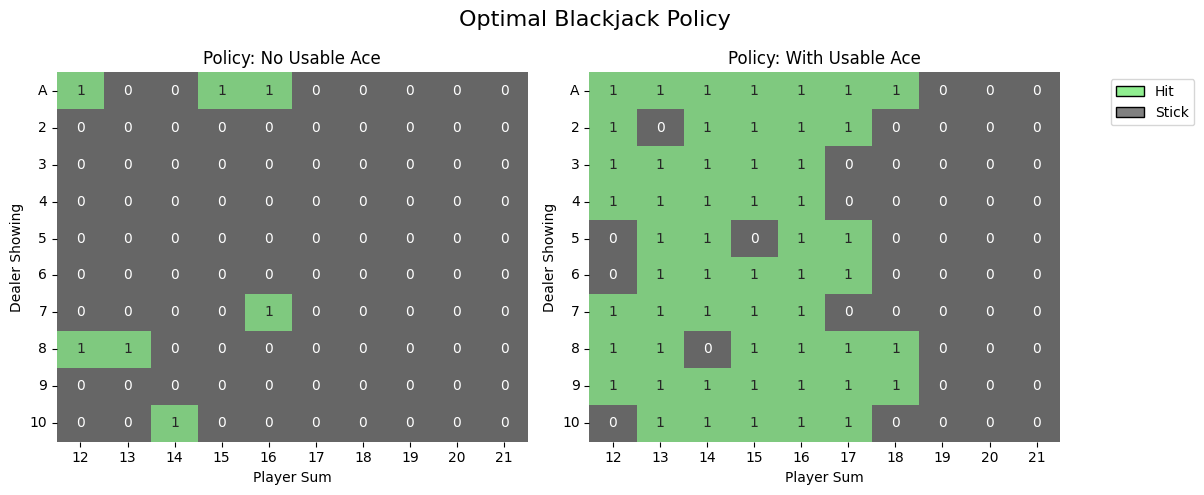

In [52]:
plot_blackjack_policy(policy)

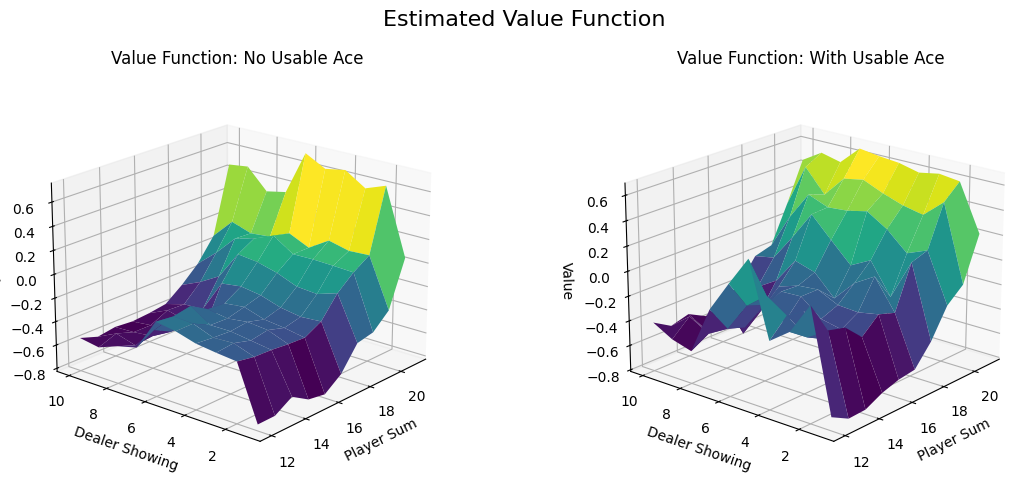

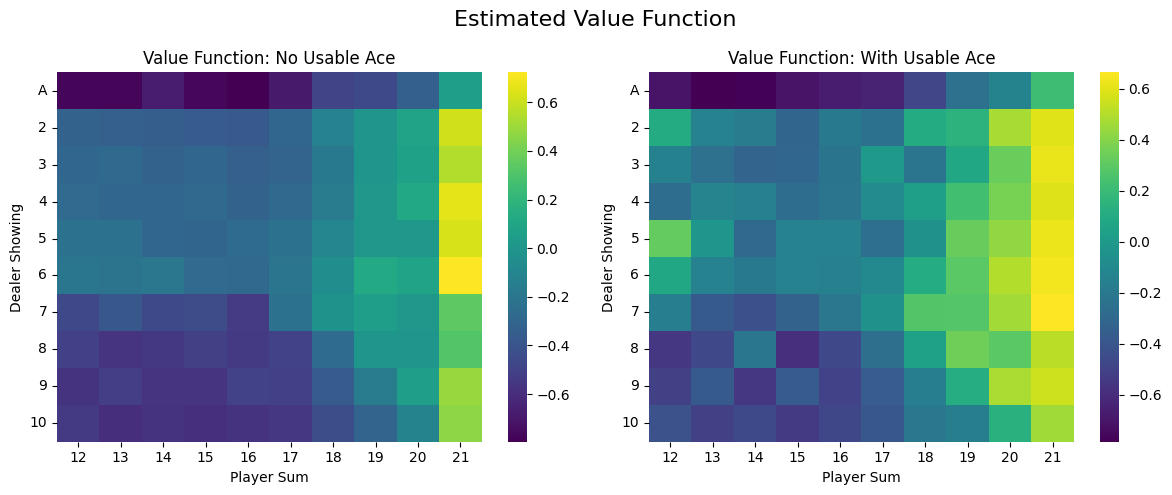

In [53]:
plot_blackjack_value_function(V)

In [54]:
average_wins(env,policy=policy,episodes=100000)

(0.41837, 0.0015599248158164544)